## Problem Statement
I assume that the goal of this analysis is to decide etiher to invest or not in certain areas. Specifically, we want to see if the company should invest in the areas where the property status is not completed yet and it is planned. Also, there are some states that the company does not currently operate. I do some analysis to find potential business oportunties in those states. There are different factors that can affect the demand for self storage such as, population, income, age distribution, size of households, etc. However, in this project, I only take the population into consideration, i.e. $land\ size = f(population)$. Since the properties are based on zip code and the zip codes can be close to each other, I map zip codes to conuties and find the aggregated total-sqft available for each county. I found this mapping using data from Census.gov. Also, I use some other data from Census.gov to get population of each county.


In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# read propertyLocations and store in propert_data df
property_data = pd.read_csv('propertyLocations.txt', encoding='ISO-8859-1',sep='\t', header=0)
property_data = property_data.drop(columns=['PropertyName', 'Address', 'PhoneNumber'])

In [3]:
# data cleaning and data type conversion
property_data['ZipCode'] = property_data['ZipCode'].fillna(0)
property_data['NumBuildings'] = property_data['NumBuildings'].fillna(0)
property_data['NumFloors'] = property_data['NumFloors'].fillna(0)

property_data['ZipCode'] = property_data['ZipCode'].astype('int')
property_data['NumBuildings'] = property_data['NumBuildings'].astype('int')
property_data['NumFloors'] = property_data['NumFloors'].astype('int')
property_data['City'] = property_data['City'].str.strip()
property_data['CompletionDate'] = pd.to_datetime(property_data['CompletionDate'])

In [4]:
# in the following we build a dictionary that maps state to its abbreviation
state_abbreviations = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
                       'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT',
                       'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA','Hawaii': 'HI',
                       'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
                       'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
                       'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
                       'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
                       'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 
                       'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
                       'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
                       'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
                       'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
                       'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
                       'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
                       'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'}

In [5]:
# this is the data for county population
county_pop = pd.read_csv('cbsa-est2022.csv', encoding='ISO-8859-1', header=0)
# We keep the data only in county level
county_pop = county_pop[county_pop['LSAD'] == 'County or equivalent']

In [6]:
# data cleaning
for i, row in county_pop.iterrows():
    county_pop.at[i, 'NAME'] = row['NAME'].split(',')[:-1][0]
    county_pop.at[i, 'State'] = row['NAME'].split(',')[-1].strip()
county_pop['County'] = county_pop['NAME'] + ', ' + county_pop['State']

In [7]:
# this file is to map zip code to county
zip_county = pd.read_csv('zip07_cbsa06.txt', encoding='ISO-8859-1', header=0)

/var/folders/vq/y0cr202s1fb3h_zn3ykl9b600000gn/T/ipykernel_14406/2060764896.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  zip_county = pd.read_csv('zip07_cbsa06.txt', encoding='ISO-8859-1', header=0)


In [8]:
counter = 0
# Data cleaning-find the counies that the property is located. 
# The information about zip->county is missing from the files 
# that I found on Census.gov. We remove them.
for i, row in property_data.iterrows():
    try:
        county = zip_county[zip_county['ZIP5'] == row['ZipCode']]['COUNTY NAME'].values[0]
        state = row['State']
        c1 = county_pop['NAME'] == county
        c2 = county_pop['State'] == state
        pop = county_pop.loc[c1 & c2, 'ESTIMATESBASE2020'].values[0]
        property_data.at[i, 'County'] = county + ', ' + state
    except:
        print(f"{ row['ZipCode'] }->county not found")
        counter += 1
print(f'number of unavailable zip->county is {counter}')

12496->county not found
12414->county not found
12192->county not found
12414->county not found
12051->county not found
12413->county not found
29438->county not found
29486->county not found
3861->county not found
11249->county not found
78665->county not found
78633->county not found
78633->county not found
78665->county not found
78633->county not found
75033->county not found
75033->county not found
78665->county not found
78633->county not found
78669->county not found
78633->county not found
78669->county not found
76692->county not found
76645->county not found
29707->county not found
29707->county not found
60642->county not found
78665->county not found
78669->county not found
78665->county not found
78633->county not found
76692->county not found
76645->county not found
76645->county not found
76055->county not found
29707->county not found
60642->county not found
76692->county not found
76645->county not found
76692->county not found
76692->county not found
76645->county not

In [9]:
# seperate the completed and planned properties
completed = property_data[property_data['PropertyStatus'] == 'Completed']
planned = property_data[property_data['PropertyStatus'] == 'Planned']

In [10]:
# here we group the completed properties based on the county they operate
group = completed.groupby('County').agg('sum')

/var/folders/vq/y0cr202s1fb3h_zn3ykl9b600000gn/T/ipykernel_14406/1611043478.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group = completed.groupby('County').agg('sum')


In [11]:
group

ZipCode  TotalSqFt  NetRentableSqFt  TotalAcres  \
County                                                              
Ada County, ID    6192663  6955687.0        6506697.0      650.41   
Adams County, CO  4493675  3163218.0        2823336.0      252.66   
Adams County, IN    93466    58900.0          55955.0        5.55   
Adams County, PA    86715   259675.0         242569.0      102.91   
Aiken County, SC   893977  1074504.0        1014020.0      147.40   
...                   ...        ...              ...         ...   
Yolo County, CA   3062468  1824757.0        1620761.0      111.25   
York County, ME     95812  1173527.0        1051572.0      258.18   
York County, PA    659255  1841885.0        1709105.0      197.41   
York County, SC   1396920  2489560.0        2239468.0      219.15   
York County, VA    165847   500083.0         463266.0       39.29   

                  NumBuildings  NumFloors  
County                                     
Ada County, ID             807         78  
Adams County, CO           524         67  
Adams County, IN            13          2  
Adams County, PA            43          6  
Aiken County, SC           242         31  
...                        ...        ...  
Yolo County, CA            180         39  
York County, ME            172         33  
York County, PA            223         45  
York County, SC            273         60  
York County, VA             79          9  

[705 rows x 6 columns]

In [12]:
# prepare the data for linear regression
x = []
y = []
counter = 0
for index, row in group.iterrows():
    c1 = county_pop['County'] == index
    # Here we use ESTIMATESBASE2020 column which is population est 2020
    x.append(county_pop.loc[c1, 'ESTIMATESBASE2020'].values[0])
    y.append(row['TotalSqFt'])

### In the following we fit a model where $x=log(population)$ and $y=log(TotalSqFt)$ for completed properties

In [13]:
# transform data to log-log
xtr = np.log(x).reshape(-1, 1)
ytr = np.log(y).reshape(-1, 1)

In [14]:
# use linear regression from sklearn
model = LinearRegression().fit(xtr, ytr)

In [15]:
print(f'regression score is {model.score(xtr, ytr):.2f}')

regression score is 0.80


In [16]:
std = np.std(model.predict(xtr) - ytr)

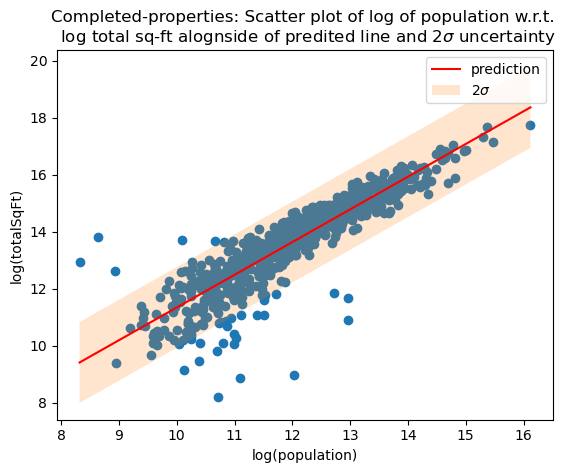

In [17]:
# plot the data and predtion model in log-log
plt.scatter(xtr, ytr)
x_test = np.linspace(np.min(xtr), np.max(xtr)).reshape(-1, 1)
y_test = model.predict(x_test)
plt.plot(x_test, y_test, 'r', label='prediction')
lower = y_test.flatten() - 2.0 * std
upper = y_test.flatten() + 2.0 * std
plt.fill_between(x_test.flatten(), lower, upper, alpha = 0.2, label = f'$2\sigma$')
plt.xlabel('log(population)')
plt.ylabel('log(totalSqFt)')
plt.title(f'Completed-properties: Scatter plot of log of population w.r.t. \n log total sq-ft alognside of predited line and 2$\sigma$ uncertainty')
plt.legend()

In [18]:
# here we group the planned properties based on the county they operate
planned = planned.dropna(subset=['TotalSqFt'])
planned_group = planned.groupby('County').agg('sum')

/var/folders/vq/y0cr202s1fb3h_zn3ykl9b600000gn/T/ipykernel_14406/3567225472.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  planned_group = planned.groupby('County').agg('sum')


### In the following we fit a model where $x=log(population)$ and $y=log(TotalSqFt)$ for planned properties

In [19]:
# prepare the data for completed properties for linear regression
x_planned = []
y_planned = []
counter = 0
for index, row in planned_group.iterrows():
    c1 = county_pop['County'] == index
    # Here we use ESTIMATESBASE2020 column which is population est 2020
    x_planned.append(county_pop.loc[c1, 'ESTIMATESBASE2020'].values[0])
    y_planned.append(row['TotalSqFt'])

Text(0.5, 1.0, 'Planned-properties: Scatter plot of log of population w.r.t. \n log total sq-ft alognside of predited line and 2$\\sigma$ uncertainty')

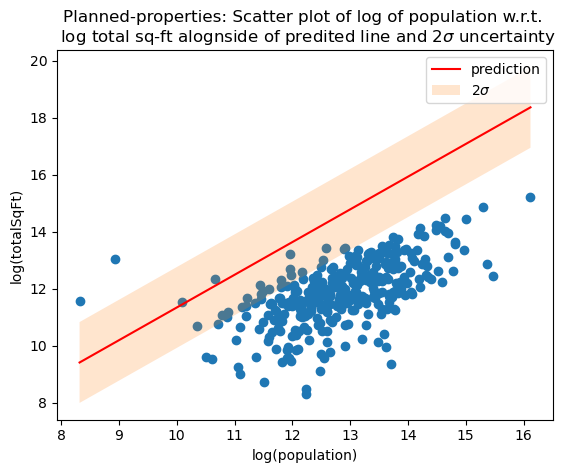

In [20]:
# plot the data and predtion model in log-log
plt.scatter(np.log(x_planned), np.log(y_planned))
y_test_planned = model.predict(np.log(x_planned).reshape(-1, 1))
plt.plot(np.sort(np.log(x_planned)), np.sort(y_test_planned.flatten()), 'r', label='prediction')
lower = y_test_planned.flatten() - 2.0 * std
upper = y_test_planned.flatten() + 2.0 * std
plt.fill_between(np.sort(np.log(x_planned)), np.sort(lower), np.sort(upper), alpha = 0.2, label = f'$2\sigma$')
plt.xlabel('log(population)')
plt.ylabel('log(totalSqFt)')
plt.legend()
plt.title(f'Planned-properties: Scatter plot of log of population w.r.t. \n log total sq-ft alognside of predited line and 2$\sigma$ uncertainty')

In the figure above, the Planned properties land sizes are below the prediction. The reason for this may be because of the exploration phase that the company would like to go through before full investment. In other words, start smaller, then expand if the financials go well. In the following, we do some cost analysis, expansion/shrinking decision making for the completed and planned properties.

In [21]:
# store the data from table B in dictionaries
annual_cash_flow = {'gross_rent': 9.0, 'other_income': 0.45,
                    'vacancy_loss': 0.95, 'operating_cost': 2.80,
                    'net_operating_income': 5.71, 'debt_service': 3.35, 
                    'net_cashflow': 2.36}
annual_development_cost ={'land': 6.82, 'cstrct_sec': 26.0, 'arch_eng': 0.72,
                   'permits_fees': 0.29, 'test_survey': 0.24, 'legal': 0.19,
                   'insurance': 0.04, 'ad_marketing': 0.67, 'equipments': 0.19,
                   'closing': 0.72, 'interest': 2.5, 'total': 38.31}

### Here are some shrinking/expansion decisions and potential savings/cashflows for the Completed properties.

In [22]:
estimation = []
county_name = []
lower = []
upper = []
obs = []
capital = []
land_change = []
capital = []
#build a dataframe to store cost analysis and expansion/shrinking decesions
for index, row in group.iterrows():
    c1 = county_pop['County'] == index
    v1 = county_pop.loc[c1, 'ESTIMATESBASE2020'].values[0]
    v2 = row['TotalSqFt']
    est = model.predict(np.log(v1).reshape(-1, 1))[0,0]
    # check if the property is within the prediction range
    if np.log(v2) < est - 2.0 * std or np.log(v2) > est + 2.0 * std:
        county_name.append(index)
        obs.append(v2)
        estimation.append(np.exp(est))
        lower.append(np.exp(est - 2.0 * std))
        upper.append(np.exp(est + 2.0 * std))
        # check if it's outside of uncertainty bars.
        if obs[-1] > upper[-1]:
            land_change.append(upper[-1] - obs[-1])
        else:
            land_change.append(lower[-1] - obs[-1])

anomaly_counties = pd.DataFrame({'County':county_name,
                                 'Total(sq-ft)': obs,
                                 'estimated_value(sq-ft)': estimation,
                                 'lower_bound(sq-ft)': lower,
                                 'upper_bound(sq-ft)': upper,
                                 'land shrink/expnad(sq-ft)': land_change})
# fill the columns based on the financial analysis provided in table B in the problem description
anomaly_counties['estimated development cost($)'] = anomaly_counties['land shrink/expnad(sq-ft)'].apply(lambda x: annual_development_cost['total'] * x if x > 0 else 0)
anomaly_counties['20% equity required($)'] = 0.2 * anomaly_counties['estimated development cost($)']
anomaly_counties['80% loan($)'] = 0.8 * anomaly_counties['estimated development cost($)']
anomaly_counties['annual loan payement with 10% interest($)'] = anomaly_counties['land shrink/expnad(sq-ft)'].apply(lambda x: x * annual_cash_flow['debt_service'] if x > 0 else 0)
net_op = annual_cash_flow['net_operating_income']
anomaly_counties['annual estimated net operating income from expanding($)'] = anomaly_counties['land shrink/expnad(sq-ft)'].apply(lambda x: x * 0.9 * net_op if x > 0 else 0)
anomaly_counties['annual cashflow from expanding($)'] = anomaly_counties['annual estimated net operating income from expanding($)'] - anomaly_counties['annual loan payement with 10% interest($)']
costs_sqft = annual_cash_flow['operating_cost'] + annual_cash_flow['debt_service']
anomaly_counties['estimated saving from shrinking($)'] = anomaly_counties['land shrink/expnad(sq-ft)'].apply(lambda x: -x * costs_sqft if x < 0 else 0)

In [23]:
anomaly_counties.to_csv('expad_shrink_completed.csv', index=False)

In [24]:
anomaly_counties

County  Total(sq-ft)  estimated_value(sq-ft)  \
0        Berks County, PA       54720.0            2.553724e+06   
1       Blount County, AL       32850.0            2.623951e+05   
2        Boise County, ID      304763.0            2.492038e+04   
3         Cass County, MI       52565.0            2.243516e+05   
4      Chester County, SC       12800.0            1.310016e+05   
5      Cullman County, AL       64598.0            4.134769e+05   
6   Cumberland County, NC      139800.0            1.921313e+06   
7        Fairfax city, VA      890232.0            9.382029e+04   
8      Garland County, AR       65670.0            4.807041e+05   
9        Henry County, IN       24180.0            2.110245e+05   
10    Kennebec County, ME      137773.0            6.121300e+05   
11    Lawrence County, AL       24300.0            1.346559e+05   
12        Lynn County, TX     1007089.0            1.749622e+04   
13        Lyon County, NV       23795.0            2.629558e+05   
14    Macoupin County, IL        3600.0            1.915977e+05   
15      Monroe County, PA        8000.0            8.724347e+05   
16    Montcalm County, MI       65750.0            3.009236e+05   
17       Moore County, NC      110051.0            4.782415e+05   
18       Pinal County, AZ      115870.0            2.529235e+06   
19       Starr County, TX        7000.0            2.972745e+05   
20      Stokes County, NC       18400.0            1.894266e+05   
21      Storey County, NV      422118.0            1.223610e+04   
22      Summit County, UT      882362.0            1.789160e+05   
23      Waller County, TX       58461.0            2.503684e+05   
24  Washington County, NY       29200.0            2.734942e+05   
25  Washington County, OK       43421.0            2.286569e+05   
26       Yates County, NY        9300.0            9.659193e+04   

    lower_bound(sq-ft)  upper_bound(sq-ft)  land shrink/expnad(sq-ft)  \
0        617485.790335        1.056138e+07              562765.790335   
1         63446.669746        1.085182e+06               30596.669746   
2          6025.703961        1.030627e+05             -201700.268016   
3         54247.810571        9.278464e+05                1682.810571   
4         31675.952619        5.417807e+05               18875.952619   
5         99977.971329        1.710008e+06               35379.971329   
6        464569.934765        7.945934e+06              324769.934765   
7         22685.577979        3.880107e+05             -502221.294852   
8        116233.393385        1.988038e+06               50563.393385   
9         51025.355533        8.727300e+05               26845.355533   
10       148011.930809        2.531574e+06               10238.930809   
11        32559.547972        5.568936e+05                8259.547972   
12         4230.555082        7.235878e+04             -934730.223769   
13        63582.239206        1.087501e+06               39787.239206   
14        46327.971084        7.923866e+05               42727.971084   
15       210953.131866        3.608111e+06              202953.131866   
16        72762.776378        1.244524e+06                7012.776378   
17       115637.928229        1.977854e+06                5586.928229   
18       611564.494607        1.046011e+07              495694.494607   
19        71880.446914        1.229432e+06               64880.446914   
20        45803.016956        7.834079e+05               27403.016956   
21         2958.666103        5.060458e+04             -371513.421091   
22        43261.560663        7.399392e+05             -142422.789518   
23        60538.630312        1.035444e+06                2077.630312   
24        66130.403143        1.131084e+06               36930.403143   
25        55288.820335        9.456516e+05               11867.820335   
26        23355.754988        3.994733e+05               14055.754988   

    estimated development cost($)  20% equity required($)   80% loan($)  \
0                    2

In [25]:
total_saving_shrinking = anomaly_counties['estimated saving from shrinking($)'].sum()
total_annual_expand = anomaly_counties['annual cashflow from expanding($)'].sum()
required_equity = anomaly_counties['20% equity required($)'].sum()
print(f'Completed-properties: Total annual potential savings from shrinking is ${total_saving_shrinking/1.0e6:.2f} million')
print(f'Completed-properties: Total annual potential cashflow from expansion is ${total_annual_expand/1.0e6:.2f} million')
print(f'Completed-properties: Required equity to exapnd is ${required_equity/1.0e6:.2f} million')

Completed-properties: Total annual potential savings from shrinking is $13.24 million
Completed-properties: Total annual potential cashflow from expansion is $3.62 million
Completed-properties: Required equity to exapnd is $15.48 million


### Here are some shrinking/expansion decisions and potential savings/cashflows for the Planned properties.

In [26]:
estimation = []
county_name = []
lower = []
upper = []
obs = []
capital = []
land_change = []
capital = []
#build a dataframe to store cost analysis and expansion/shrinking decesions
for index, row in planned_group.iterrows():
    c1 = county_pop['County'] == index
    v1 = county_pop.loc[c1, 'ESTIMATESBASE2020'].values[0]
    v2 = row['TotalSqFt']
    est = model.predict(np.log(v1).reshape(-1, 1))[0,0]
    if np.log(v2) < est - 2.0 * std or np.log(v2) > est + 2.0 * std:
        county_name.append(index)
        obs.append(v2)
        estimation.append(np.exp(est))
        lower.append(np.exp(est - 2.0 * std))
        upper.append(np.exp(est + 2.0 * std))
        # check if it's outside of uncertainty bars.
        if obs[-1] > upper[-1]:
            land_change.append(upper[-1] - obs[-1])
        else:
            land_change.append(lower[-1] - obs[-1])

anomaly_counties = pd.DataFrame({'County':county_name,
                                 'Total(sq-ft)': obs,
                                 'estimated_value(sq-ft)': estimation,
                                 'lower_bound(sq-ft)': lower,
                                 'upper_bound(sq-ft)': upper,
                                 'land shrink/expnad(sq-ft)': land_change})
# fill the columns based on the financial analysis provided in table B in the problem description
anomaly_counties['estimated development cost($)'] = anomaly_counties['land shrink/expnad(sq-ft)'].apply(lambda x: annual_development_cost['total'] * x if x > 0 else 0)
anomaly_counties['20% equity required($)'] = 0.2 * anomaly_counties['estimated development cost($)']
anomaly_counties['80% loan($)'] = 0.8 * anomaly_counties['estimated development cost($)']
anomaly_counties['annual loan payement with 10% interest($)'] = anomaly_counties['land shrink/expnad(sq-ft)'].apply(lambda x: x * annual_cash_flow['debt_service'] if x > 0 else 0)
net_op = annual_cash_flow['net_operating_income']
anomaly_counties['annual estimated net operating income from expanding($)'] = anomaly_counties['land shrink/expnad(sq-ft)'].apply(lambda x: x * 0.9 * net_op if x > 0 else 0)
anomaly_counties['annual cashflow from expanding($)'] = anomaly_counties['annual estimated net operating income from expanding($)'] - anomaly_counties['annual loan payement with 10% interest($)']
costs_sqft = annual_cash_flow['operating_cost'] + annual_cash_flow['debt_service']
anomaly_counties['estimated saving from shrinking($)'] = anomaly_counties['land shrink/expnad(sq-ft)'].apply(lambda x: -x * costs_sqft if x < 0 else 0)

In [27]:
anomaly_counties.to_csv('expad_shrink_planned.csv', index=False)

In [28]:
anomaly_counties

County  Total(sq-ft)  estimated_value(sq-ft)  \
0        Ada County, ID      391317.0            3.010903e+06   
1      Adams County, CO      118495.0            3.183512e+06   
2      Aiken County, SC      188265.0            8.753401e+05   
3    Alameda County, CA      361598.0            1.227175e+07   
4     Albany County, NY      328393.0            1.790787e+06   
..                  ...           ...                     ...   
301   Wright County, MN       67800.0            7.138008e+05   
302     Yolo County, CA      104390.0            1.164274e+06   
303     York County, ME      115057.0            1.136981e+06   
304     York County, PA      126710.0            2.743377e+06   
305     York County, SC      169050.0            1.578686e+06   

     lower_bound(sq-ft)  upper_bound(sq-ft)  land shrink/expnad(sq-ft)  \
0          7.280310e+05        1.245213e+07               3.367140e+05   
1          7.697675e+05        1.316599e+07               6.512725e+05   
2          2.116557e+05        3.620127e+06               2.339066e+04   
3          2.967287e+06        5.075202e+07               2.605689e+06   
4          4.330090e+05        7.406121e+06               1.046160e+05   
..                  ...                 ...                        ...   
301        1.725958e+05        2.952052e+06               1.047958e+05   
302        2.815193e+05        4.815063e+06               1.771293e+05   
303        2.749199e+05        4.702189e+06               1.598629e+05   
304        6.633436e+05        1.134573e+07               5.366336e+05   
305        3.817234e+05        6.528940e+06               2.126734e+05   

     estimated development cost($)  20% equity required($)   80% loan($)  \
0                     1.289951e+07            2.579903e+06  1.031961e+07   
1                     2.495025e+07            4.990050e+06  1.996020e+07   
2                     8.960962e+05            1.792192e+05  7.168770e+05   
3                     9.982393e+07            1.996479e+07  7.985914e+07   
4                     4.007841e+06            8.015682e+05  3.206273e+06   
..                             ...                     ...           ...   
301                   4.014725e+06            8.029451e+05  3.211780e+06   
302                   6.785823e+06            1.357165e+06  5.428658e+06   
303                   6.124349e+06            1.224870e+06  4.899479e+06   
304                   2.055843e+07            4.111687e+06  1.644675e+07   
305                   8.147520e+06            1.629504e+06  6.518016e+06   

     annual loan payement with 10% interest($)  \
0                                 1.127992e+06   
1                                 2.181763e+06   
2                                 7.835871e+04   
3                                 8.729057e+06   
4                                 3.504638e+05   
..                                         ...   
301                               3.510658e+05   
302                               5.933831e+05   
303                               5.355408e+05   
304                               1.797723e+06   
305                               7.124560e+05   

     annual estimated net operating income from expanding($)  \
0                                         1.730373e+06         
1                                         3.346889e+06         
2                                         1.202046e+05         
3                                         1.339063e+07         
4                                         5.376219e+05         
..                                                 ...         
301                                       5.385454e+05         
302                                       9.102674e+05         
303                                       8.215356e+05         
304                                       2.757760e+06         
305                                       1.092929e+06         

     annual cashflow from expanding($)  estimated saving from sh

In [29]:
total_saving_shrinking = anomaly_counties['estimated saving from shrinking($)'].sum()
total_annual_expand = anomaly_counties['annual cashflow from expanding($)'].sum()
required_equity = anomaly_counties['20% equity required($)'].sum()
print(f'Planned-properties: Total annual potential savings from shrinking is ${total_saving_shrinking/1.0e6:.2f} million')
print(f'Planned-properties: Total annual potential cashflow from expansion is ${total_annual_expand/1.0e6:.2f} million')
print(f'Planned-properties: Required equity to exapnd is ${required_equity/1.0e9:.2f} billion')

Planned-properties: Total annual potential savings from shrinking is $2.54 million
Planned-properties: Total annual potential cashflow from expansion is $467.33 million
Planned-properties: Required equity to exapnd is $2.00 billion


### In the following, we find the states that Public Storage does not operate.

In [30]:
states = property_data['State'].unique()
all_states = np.array(['AL', 'AK', 'AZ', 'AR', 'CA',  'CO', 'CT', 
                       'DE', 'FL', 'GA',  'HI', 'ID', 'IL', 'IN', 
                       'IA',  'KS', 'KY', 'LA', 'ME', 'MD',  'MA', 
                       'MI', 'MN', 'MS', 'MO',  'MT', 'NE', 'NV', 
                       'NH', 'NJ',  'NM', 'NY', 'NC', 'ND', 'OH',  
                       'OK', 'OR', 'PA', 'RI', 'SC',  'SD', 'TN', 
                       'TX', 'UT', 'VT',  'VA', 'WA', 'WV', 'WI', 
                       'WY', 'DC'])
states_with_no_business = []
for i in all_states:
    if i not in states:
        states_with_no_business.append(i)
print(f'The states that Public Storage does not operate are {states_with_no_business}')

The states that Public Storage does not operate are ['MT', 'ND', 'SD', 'VT', 'WV', 'WY']


In [31]:
grow = county_pop[county_pop['State'].isin(states_with_no_business)][['County', 'ESTIMATESBASE2020']]
grow

County  ESTIMATESBASE2020
146       Fayette County, WV              40485
147       Raleigh County, WV              74581
153        Carbon County, MT              10476
154    Stillwater County, MT               8959
155   Yellowstone County, MT             164722
...                      ...                ...
2737     Richland County, ND              16528
2753    Codington County, SD              28323
2754       Hamlin County, SD               6159
2771     Williams County, ND              40950
2794      Yankton County, SD              23311

[94 rows x 2 columns]

#### To invest in new states, I recommend to  invest in counties with population in range of one standard deviation of population mean that the comany currently operates.

In the following we get the histogrm plot of lof of counties' population that Public Storage operates. Then we find the lower and upper bound of population in two standarad deviation. These are the counties population that I recommend Public Storage to develop business. 

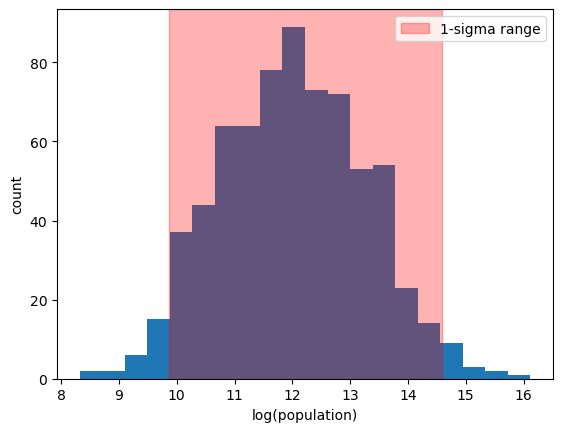

In [32]:
hist_column = plt.hist(xtr, bins = 20)[1]
mean_value = np.mean(hist_column)
std_dev = np.std(hist_column)

# Calculate the 1-sigma range (95% confidence interval)
lower_bound = mean_value - 1 * std_dev
upper_bound = mean_value + 1 * std_dev

# Mark the 2-sigma range with shading
plt.axvspan(lower_bound, upper_bound, color='red', alpha=0.3, label='1-sigma range')
plt.xlabel('log(population)')
plt.ylabel('count')
plt.legend()

In the following, I use the tables in the problem description. I table B which describes the developement cost is one-time cost. 

In [33]:
# build the dataframe, based on the business info. in table B
c1 = grow['ESTIMATESBASE2020'] > np.exp(lower_bound)
c2 = grow['ESTIMATESBASE2020'] < np.exp(upper_bound)
grow = grow[c1 & c2][['County', 'ESTIMATESBASE2020']]
grow['recommended storage sq-ft'] = np.exp(model.predict(np.log(grow['ESTIMATESBASE2020']).to_numpy().reshape(-1, 1)))
grow['estimated development cost($)'] = grow['recommended storage sq-ft'] * annual_development_cost['total']
grow['20% equity required($)'] = 0.2 * grow['estimated development cost($)']
grow['80% loan($)'] = 0.8 * grow['estimated development cost($)']
grow['annual loan payement with 10% interest($)'] = grow['recommended storage sq-ft'] * annual_cash_flow['debt_service']
grow['annual estimated net operating income($)'] = annual_cash_flow['net_operating_income'] * grow['recommended storage sq-ft']
grow['annual estimated net cashflow($)'] = annual_cash_flow['net_cashflow'] * grow['recommended storage sq-ft']
grow.rename(columns={'ESTIMATESBASE2020': 'Population'}, inplace=True)

In [34]:
grow.to_csv('expand_new_states.csv', index=False)

In [35]:
grow

County  Population  recommended storage sq-ft  \
146       Fayette County, WV       40485              169832.816118   
147       Raleigh County, WV       74581              342564.101909   
155   Yellowstone County, MT      164722              851034.025149   
167      Burleigh County, ND       98466              471314.095394   
168        Morton County, ND       33287              135638.142252   
...                      ...         ...                        ...   
2612     Sheridan County, WY       30925              124644.181248   
2630     Lawrence County, SD       25766              101074.953304   
2753    Codington County, SD       28323              112677.066492   
2771     Williams County, ND       40950              172074.929584   
2794      Yankton County, SD       23311               90095.349847   

      estimated development cost($)  20% equity required($)   80% loan($)  \
146                    6.506295e+06            1.301259e+06  5.205036e+06   
147                    1.312363e+07            2.624726e+06  1.049890e+07   
155                    3.260311e+07            6.520623e+06  2.608249e+07   
167                    1.805604e+07            3.611209e+06  1.444483e+07   
168                    5.196297e+06            1.039259e+06  4.157038e+06   
...                             ...                     ...           ...   
2612                   4.775119e+06            9.550237e+05  3.820095e+06   
2630                   3.872181e+06            7.744363e+05  3.097745e+06   
2753                   4.316658e+06            8.633317e+05  3.453327e+06   
2771                   6.592191e+06            1.318438e+06  5.273752e+06   
2794                   3.451553e+06            6.903106e+05  2.761242e+06   

      annual loan payement with 10% interest($)  \
146                                5.689399e+05   
147                                1.147590e+06   
155                                2.850964e+06   
167                                1.578902e+06   
168                                4.543878e+05   
...                                         ...   
2612                               4.175580e+05   
2630                               3.386011e+05   
2753                               3.774682e+05   
2771                               5.764510e+05   
2794                               3.018194e+05   

      annual estimated net operating income($)  \
146                               9.697454e+05   
147                               1.956041e+06   
155                               4.859404e+06   
167                               2.691203e+06   
168                               7.744938e+05   
...                                        ...   
2612                              7.117183e+05   
2630                              5.771380e+05   
2753                              6.433860e+05   
2771                              9.825478e+05   
2794                              5.144444e+05   

      annual estimated net cashflow($)  
146                       4.008054e+05  
147                       8.084513e+05  
155                       2.008440e+06  
167                       1.112301e+06  
168                       3.201060e+05  
...                                ...  
2612                      2.941603e+05  
2630                      2.385369e+05  
2753                      2.659179e+05  
2771                      4.060968e+05  
2794                      2.126250e+05  

[68 rows x 9 columns]

In [36]:
total_annual_expand = grow['annual estimated net cashflow($)'].sum()
required_equity = grow['20% equity required($)'].sum()
print(f'Planned-properties: Total annual potential cashflow from expansion is ${total_annual_expand/1.0e6:.2f} million')
print(f'Planned-properties: Required equity to exapnd is ${required_equity/1.0e6:.2f} million')

Planned-properties: Total annual potential cashflow from expansion is $45.06 million
Planned-properties: Required equity to exapnd is $146.31 million
